In [1]:
import numpy as np

import sys
sys.path.append('..')

import nibabel as nib
from matplotlib import pyplot as plt
import os

from fetal_net.augment import augment_data
from fetal_net.normalize import auto_contrast_enhancement

C:\Users\Shai\AppData\Roaming\Python\Python37\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Shai\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Shai\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklea

2852
2852
1127


In [2]:
def slice_it(arr, inds):
    return arr[inds[0][0]:inds[0][1], inds[1][0]: inds[1][1], inds[2][0]:inds[2][1]]

In [3]:
vol = nib.load(r'D:\placenta_data_no_holes\188\volume.nii')
mask = nib.load(r'D:\placenta_data_no_holes\188\truth.nii')
vol.shape

c:\users\shai\appdata\local\programs\python\python37\lib\site-packages\nibabel\nifti1.py:1682: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  magic = np.asscalar(hdr['magic'])


(256, 256, 90)

In [52]:
patch_corner = [70, 70, 50]
patch_shape = [128,128,5]
data_range = [(start, start + size) for start, size in zip(patch_corner, patch_shape)]
data_range

[(70, 198), (70, 198), (50, 55)]

In [4]:
truth_index = 2
truth_size = 1
truth_range = data_range[:2] + [(patch_corner[2] + truth_index,
                                patch_corner[2] + truth_index + truth_size)]
truth_range

[(70, 198), (70, 198), (32, 33)]

In [28]:
ids_to_check = [str(x) for x in [35, 37, 52, 59, 91, 101, 133]]
vols = []
for cur_id in ids_to_check:
    vol = nib.load(r'D:\dafi_april_2020\{0}\volume.nii'.format(cur_id)).get_data()
    vols.append(vol)
    avg_ = vol.mean(axis=(-1, -2, -3))
    std_ = vol.std(axis=(-1, -2, -3))
    min_ = vol.min(axis=(-1, -2, -3))
    max_ = vol.max(axis=(-1, -2, -3))
    quan_99 = np.quantile(vol, 0.999)
    vol[vol > quan_99] = quan_99
    new_avg_ = vol.mean(axis=(-1, -2, -3))
    new_std_ = vol.std(axis=(-1, -2, -3))
    print(f"ID {cur_id}: avg {avg_}, std {std_}, min {min_}, max {max_}")
    print(f"ID {cur_id}: qunatile99 {quan_99}, new avg {new_avg_}, new std {new_std_}")

c:\users\shai\appdata\local\programs\python\python37\lib\site-packages\nibabel\nifti1.py:1682: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  magic = np.asscalar(hdr['magic'])


ID 35: avg 111.24937161532316, std 161.59558971202227, min 0, max 2051
ID 35: qunatile99 1227.0, new avg 111.08846647089177, new std 160.33392345686983
ID 37: avg 144.53490009307862, std 244.59222862443502, min 0, max 4934
ID 37: qunatile99 1954.0, new avg 144.11524963378906, new std 240.7591228303749
ID 52: avg 125.32671217484908, std 190.9563640276558, min 0, max 3434
ID 52: qunatile99 1641.0, new avg 124.90392286127263, new std 186.7651481725699
ID 59: avg 169.62093210220337, std 211.02340306086523, min 0, max 7063
ID 59: qunatile99 2325.0, new avg 168.9887549082438, new std 202.15898270525656
ID 91: avg 167.1372219351835, std 199.6654392783316, min 0, max 4590
ID 91: qunatile99 1440.0, new avg 166.83256406562273, new std 197.15844929270983
ID 101: avg 139.73498596191405, std 171.20568663995928, min 0, max 2852
ID 101: qunatile99 1127.0, new avg 139.55134628295897, new std 169.8987837111137
ID 133: avg 123.88888359069824, std 159.8929459205207, min 0, max 2263
ID 133: qunatile99 120

## Check normalization

In [14]:
from scipy.stats import percentileofscore

In [15]:
print(percentileofscore(vols[3].flatten(), 1177))
print(percentileofscore(vols[3].flatten(), 2354))

99.54156875610352
99.90463256835938


In [16]:
print(percentileofscore(vols[5].flatten(), 578.7))
print(percentileofscore(vols[5].flatten(), 1157.3))

96.78549194335938
99.92066955566406


In [13]:
for q in range(20):
    print(np.quantile(vols[3].flatten(), ((q+1)*5)/100))

34.0
51.0
57.0
61.0
65.0
68.0
72.0
76.0
81.0
88.0
99.0
117.0
141.0
168.0
202.0
244.0
299.0
388.0
555.0
7063.0


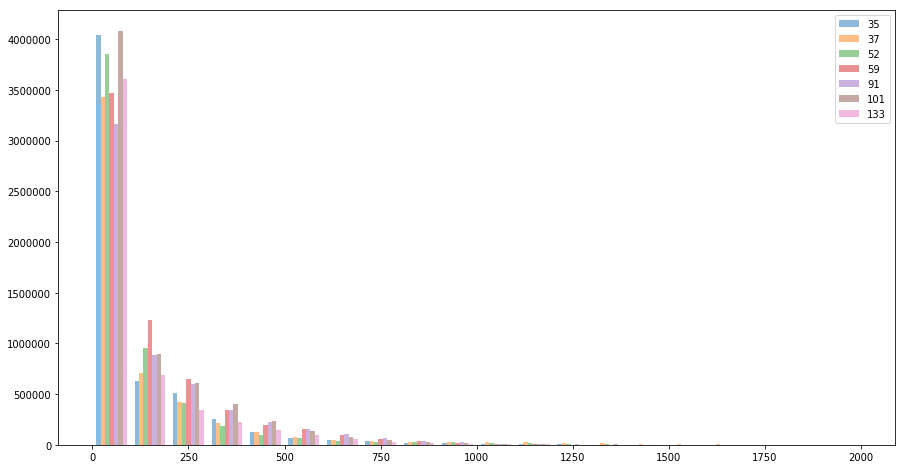

In [10]:
plt.figure(figsize=(15,8))
plt.hist([v.flatten() for v in vols], bins=20, label=ids_to_check, alpha=0.5, range=(0,2000))
plt.legend()

In [43]:
id1 = '52'
id2 = '101'
vol1 = nib.load(r'D:\dafi_april_2020\{0}\volume.nii'.format(id1)).get_data() # D:\placenta_data_no_holes
vol2 = nib.load(r'D:\dafi_april_2020\{0}\volume.nii'.format(id2)).get_data()

c:\users\shai\appdata\local\programs\python\python37\lib\site-packages\nibabel\nifti1.py:1682: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  magic = np.asscalar(hdr['magic'])


In [44]:
m1 = vol1.mean(axis=(-1, -2, -3))
m2 = vol2.mean(axis=(-1, -2, -3))
std1 = vol1.std(axis=(-1, -2, -3))
std2 = vol2.std(axis=(-1, -2, -3))

In [45]:
min1 = vol1.min(axis=(-1, -2, -3))
min2 = vol2.min(axis=(-1, -2, -3))
max1 = vol1.max(axis=(-1, -2, -3))
max2 = vol2.max(axis=(-1, -2, -3))

In [46]:
print(m1, m2, std1, std2)
print(min1, min2, max1, max2)

125.32671217484908 139.73498596191405 190.9563640276558 171.20568663995928
0 0 3434 2852


In [47]:
vol2.max()

2852

In [48]:
vol1 = np.clip(vol1, np.min(vol1.flatten()), np.quantile(vol1.flatten(), 0.999))
vol2 = np.clip(vol2, np.min(vol2.flatten()), np.quantile(vol2.flatten(), 0.999))

In [49]:
vol1_normed = (vol1 - m1) / std1
vol2_normed = (vol2 - m2) / std2

In [50]:
vol1_normed_else = (vol1 - min1) / (max1 - min1)
vol2_normed_else = (vol2 - min2) / (max2 - min2)

In [37]:
vol1_contr_enh = vol1.copy()
qunat99 = np.quantile(vol1, 0.999)
vol1_contr_enh[vol1_contr_enh > qunat99] = qunat99
vol2_contr_enh = vol2.copy()
qunat99 = np.quantile(vol2, 0.999)
vol2_contr_enh[vol2_contr_enh > qunat99] = qunat99

In [27]:
vol1_all = nib.load(r'D:\dafi_april_2020\{0}\volume.nii'.format(id1))
nib.save(nib.Nifti1Image(vol1_contr_enh, vol1_all.affine, header=vol1_all.header),
             os.path.join(r"D:\dafi_april_2020\52", f'reduced_window.nii'))
vol2_all = nib.load(r'D:\dafi_april_2020\{0}\volume.nii'.format(id2))
nib.save(nib.Nifti1Image(vol2_contr_enh, vol2_all.affine, header=vol2_all.header),
             os.path.join(r"D:\dafi_april_2020\101", f'reduced_window.nii'))

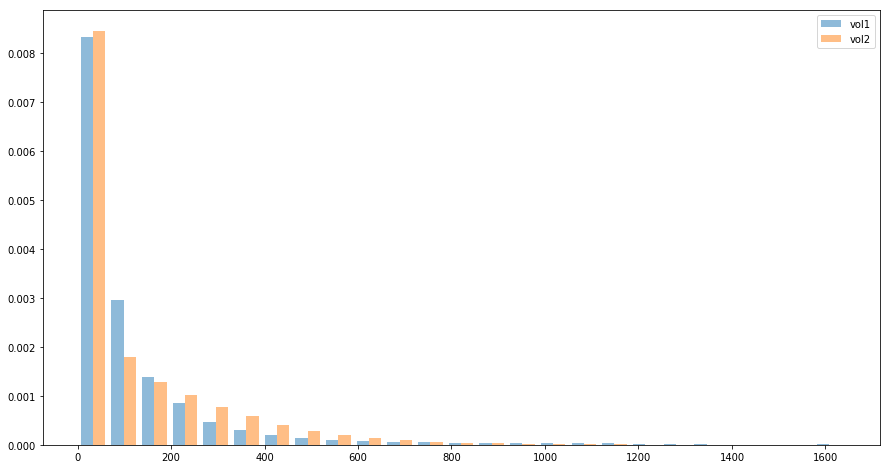

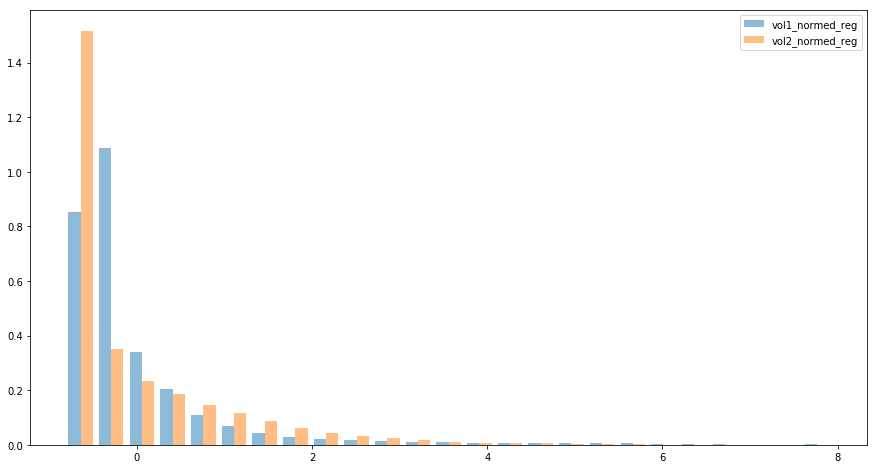

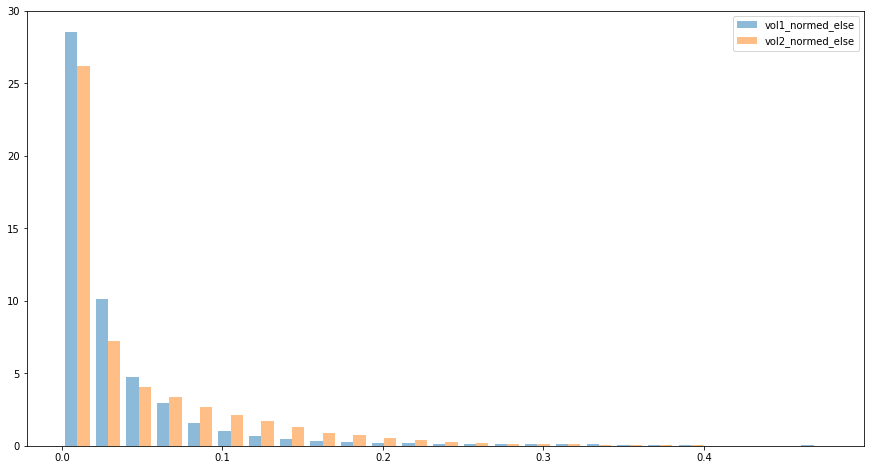

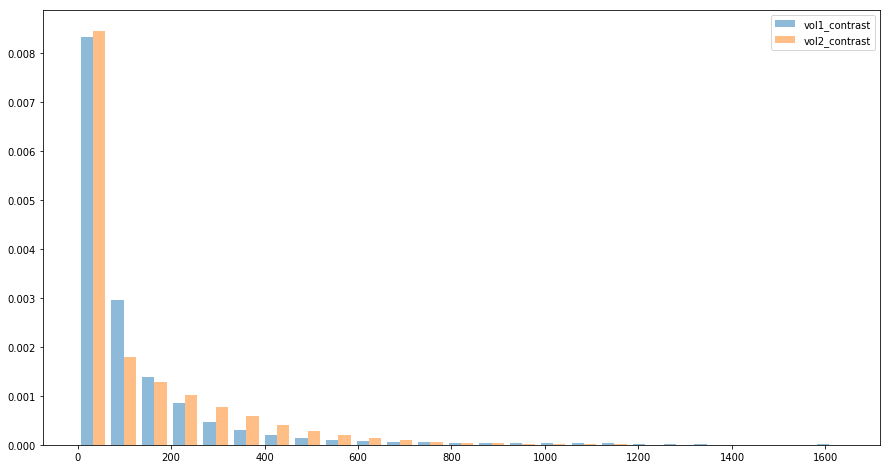

In [55]:
plt.figure(figsize=(15,8))
plt.hist([vol1.flatten(), vol2.flatten()], bins=25, label=['vol1', 'vol2'], alpha=0.5, density=True)
plt.legend()
plt.figure(figsize=(15,8))
plt.hist([vol1_normed.flatten(), vol2_normed.flatten()], bins=25, label=['vol1_normed_reg', 'vol2_normed_reg'], alpha=0.5, density=True)
plt.legend()
plt.figure(figsize=(15,8))
plt.hist([vol1_normed_else.flatten(), vol2_normed_else.flatten()], bins=25, label=['vol1_normed_else', 'vol2_normed_else'], alpha=0.5, density=True)
plt.legend()
plt.figure(figsize=(15,8))
plt.hist([vol1_contr_enh.flatten(), vol2_contr_enh.flatten()], bins=25, label=['vol1_contrast', 'vol2_contrast'], alpha=0.5, density=True)
plt.legend()

In [56]:
from skimage import exposure

In [62]:
gamma_corrected_vol_2 = exposure.adjust_gamma(vol2, 1.2)

In [63]:
logarithmic_corrected_vol_2 = exposure.adjust_log(vol2, 1)

c:\users\shai\appdata\local\programs\python\python37\lib\site-packages\nibabel\nifti1.py:1682: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  magic = np.asscalar(hdr['magic'])


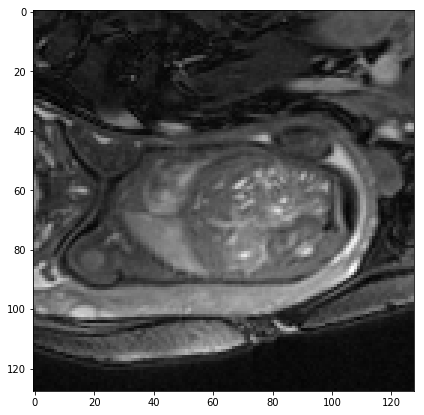

In [75]:
vol2 = nib.load(r'D:\dafi_april_2020\{0}\volume.nii'.format(id2)).get_data()
vol2_all = nib.load(r'D:\dafi_april_2020\{0}\volume.nii'.format(id2))
plt.figure(figsize = (8,7))
plt.imshow(slice_it(vol2, data_range)[..., 2], cmap='gray')
# for i in range(10):
#     cur_gamma = 0.5 + (i+1)*0.1
#     gamma_corrected_vol_2 = exposure.adjust_gamma(vol2, cur_gamma)
#     plt.figure(figsize = (8,7))
#     plt.imshow(slice_it(gamma_corrected_vol_2, data_range)[..., 2], cmap='gray')
#     nib.save(nib.Nifti1Image(gamma_corrected_vol_2, vol2_all.affine, header=vol2_all.header),
#              os.path.join(r"D:\dafi_april_2020\101", f'gamma_corrected_{cur_gamma}.nii'))
# plt.figure(figsize = (8,7))
# plt.imshow(slice_it(logarithmic_corrected_vol_2, data_range)[..., 2], cmap='gray')

In [70]:
vol2_max = vol2.max()
vol2_quan99 = np.quantile(vol2, 0.999)
vol2_clipped = np.clip(vol2, np.min(vol2), vol2_quan99)
ratio = vol2_max / vol2_quan99
vol2_stretched = (vol2_clipped * ratio).round()
nib.save(nib.Nifti1Image(vol2_stretched, vol2_all.affine, header=vol2_all.header),
             os.path.join(r"D:\dafi_april_2020\101", f'stretched_vol.nii'))

c:\users\shai\appdata\local\programs\python\python37\lib\site-packages\nibabel\nifti1.py:1682: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  magic = np.asscalar(hdr['magic'])
c:\users\shai\appdata\local\programs\python\python37\lib\site-packages\nibabel\analyze.py:1060: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  slope = (np.asscalar(hdr['scl_slope']) if hdr.has_data_slope


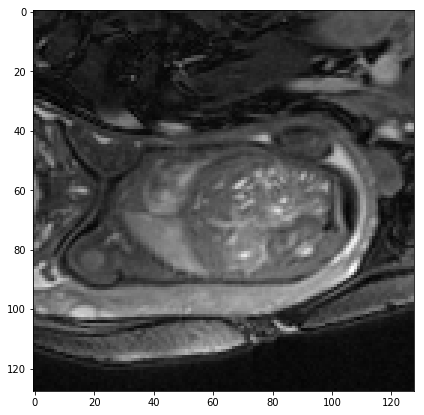

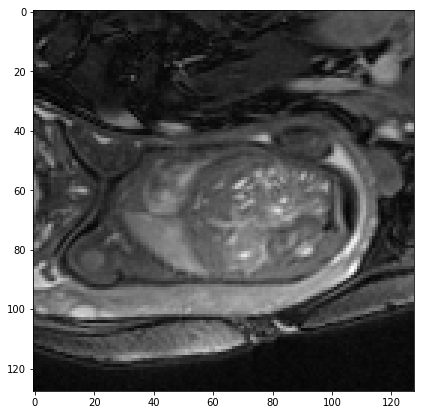

In [76]:
plt.figure(figsize = (8,7))
plt.imshow(slice_it(vol2, data_range)[..., 2], cmap='gray')
plt.figure(figsize = (8,7))
plt.imshow(slice_it(vol2_stretched, data_range)[..., 2], cmap='gray')

In [71]:
print(vol2.mean(), vol2.std())
print(vol2_stretched.mean(), vol2_stretched.std())

139.73498596191405 171.20568663995928
353.15603439331056 429.94428323285086


In [72]:
vol2_n = (vol2 - vol2.mean()) / vol2.std()
vol2_stretched_n = (vol2_stretched - vol2_stretched.mean()) / vol2_stretched.std()

In [73]:
print(vol2_n.min(), vol2_n.max())
print(vol2_stretched_n.min(), vol2_stretched_n.max())

-0.8161819195630621 15.842143256268717
-0.821399535162669 5.812018122016419


c:\users\shai\appdata\local\programs\python\python37\lib\site-packages\skimage\exposure\exposure.py:458: RuntimeWarning: overflow encountered in power
  out = (2 ** (image / scale) - 1) * scale * gain
c:\users\shai\appdata\local\programs\python\python37\lib\site-packages\skimage\exposure\exposure.py:458: RuntimeWarning: overflow encountered in multiply
  out = (2 ** (image / scale) - 1) * scale * gain


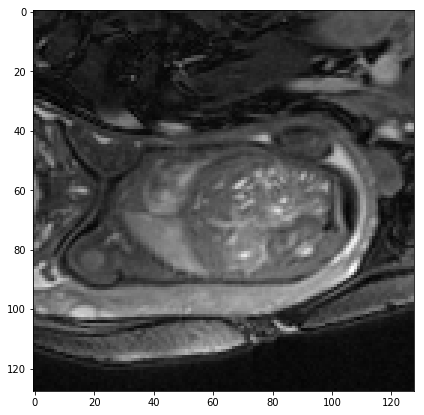

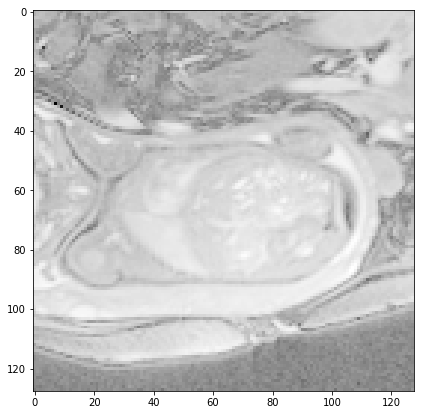

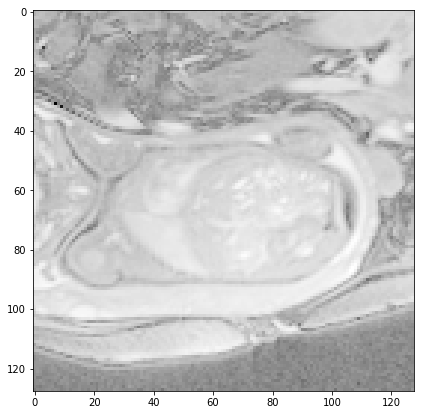

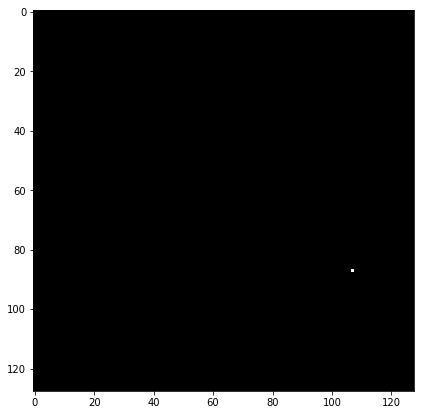

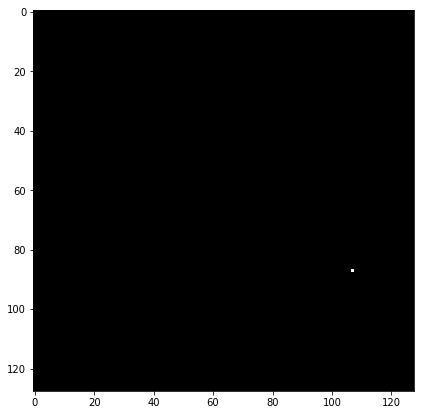

In [66]:
plt.figure(figsize = (8,7))
plt.imshow(slice_it(vol2, data_range)[..., 2], cmap='gray')
for i in range(2):
    cur_gain = i+1
    log_corrected_vol_2 = exposure.adjust_log(vol2, cur_gain)
    plt.figure(figsize = (8,7))
    plt.imshow(slice_it(log_corrected_vol_2, data_range)[..., 2], cmap='gray')
for i in range(2):
    cur_gain = i+1
    log_corrected_vol_2 = exposure.adjust_log(vol2, cur_gain, inv=True)
    plt.figure(figsize = (8,7))
    plt.imshow(slice_it(log_corrected_vol_2, data_range)[..., 2], cmap='gray')

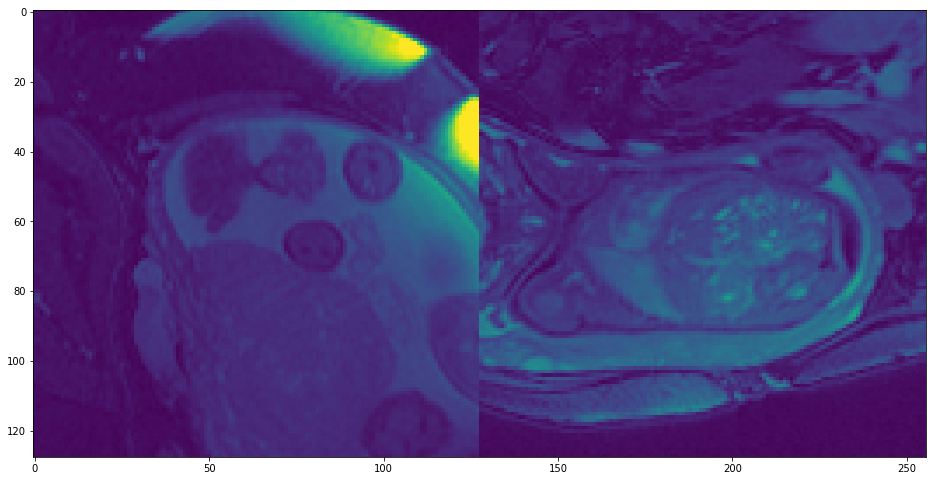

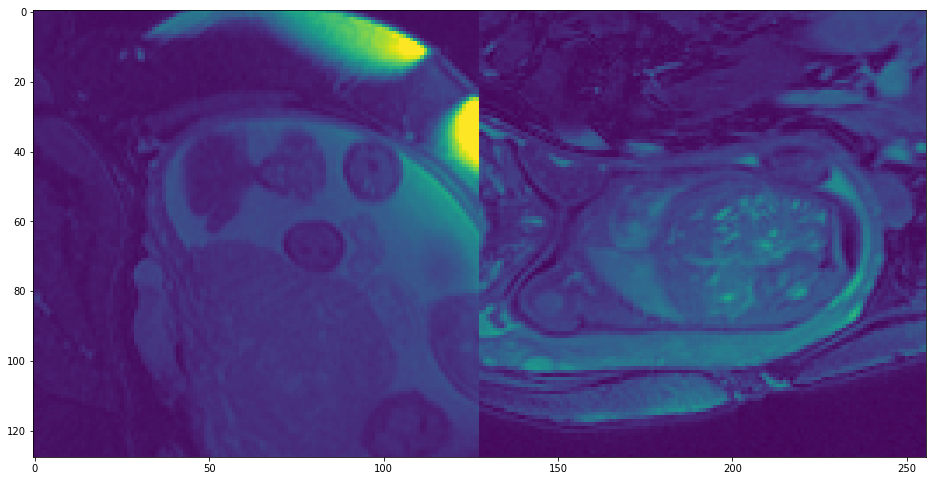

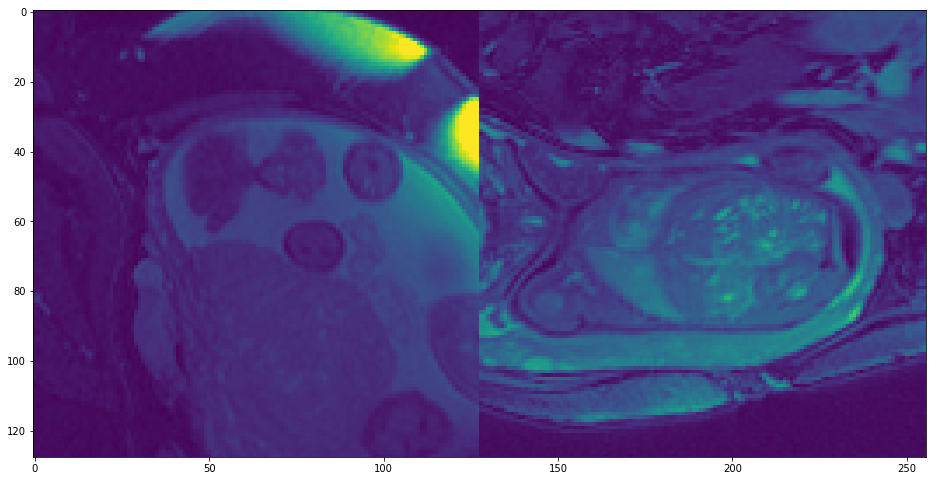

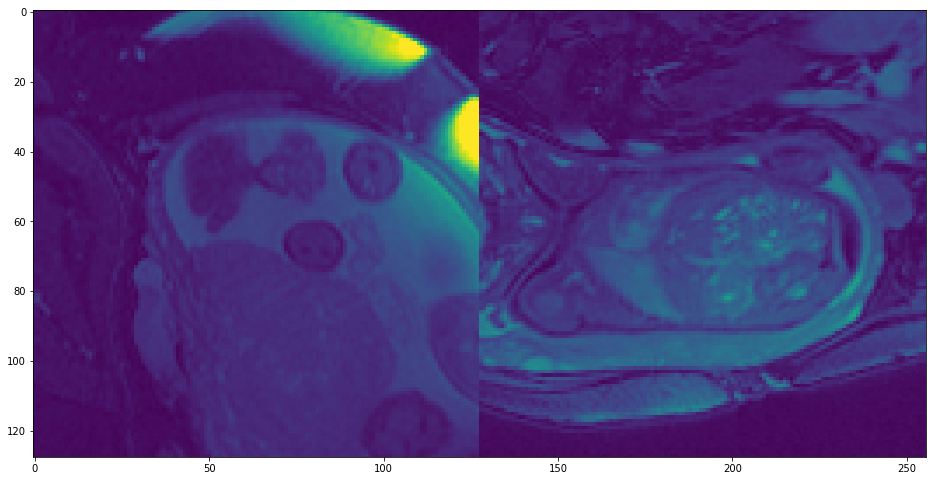

In [54]:
plt.figure(figsize = (16,14))
plt.imshow(np.c_[slice_it(vol1, data_range)[..., 2], slice_it(vol2, data_range)[..., 2]]) #, cmap='gray')
plt.figure(figsize = (16,14))
plt.imshow(np.c_[slice_it(vol1_normed, data_range)[..., 2], slice_it(vol2_normed, data_range)[..., 2]]) #, cmap='gray')
plt.figure(figsize = (16,14))
plt.imshow(np.c_[slice_it(vol1_normed_else, data_range)[..., 2], slice_it(vol2_normed_else, data_range)[..., 2]]) #, cmap='gray')
plt.figure(figsize = (16,14))
plt.imshow(np.c_[slice_it(vol1_contr_enh, data_range)[..., 2], slice_it(vol2_contr_enh, data_range)[..., 2]]) #, cmap='gray')

# Gaussian Filter

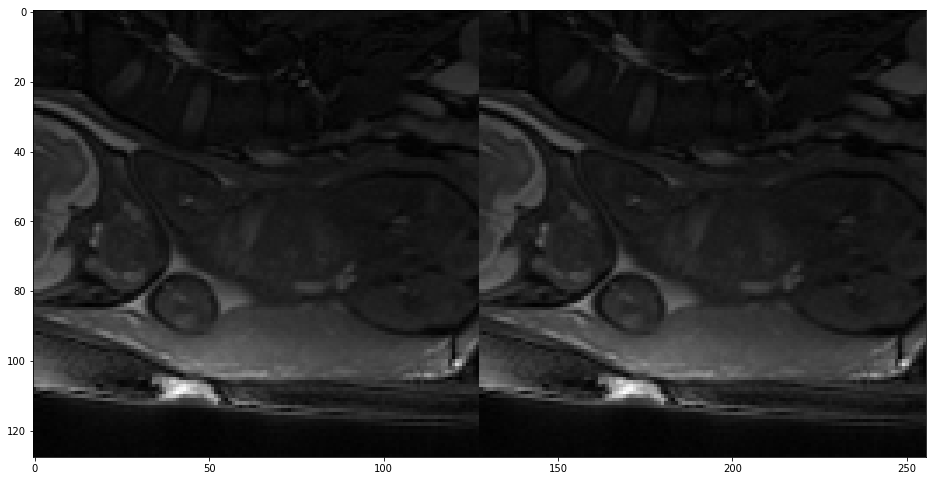

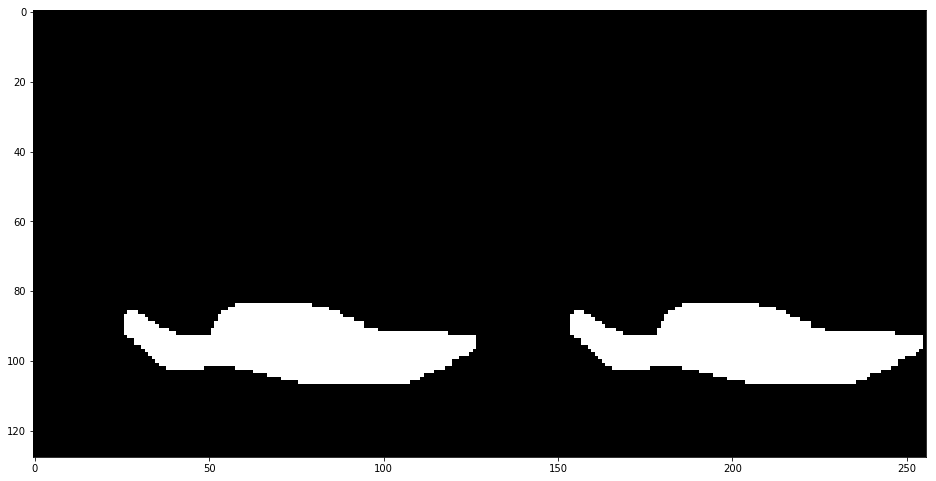

In [6]:
data = vol.get_fdata()
truth = mask.get_fdata()
data2, truth2, _, _, _ = augment_data(data, truth, data.min(), data.max(), data_range=data_range, truth_range=truth_range,
                           gaussian_filter={
            'max_sigma': 1.5,
            'prob': 1,
        }, transpose_prob=0.5)
plt.figure(figsize = (16,14))
plt.imshow(np.c_[slice_it(data, data_range)[..., 2], data2[..., 2]], cmap='gray')
plt.figure(figsize = (16,14))
plt.imshow(np.c_[slice_it(truth, truth_range)[..., 0], truth2[..., 0]], cmap='gray')

# Shot Noise

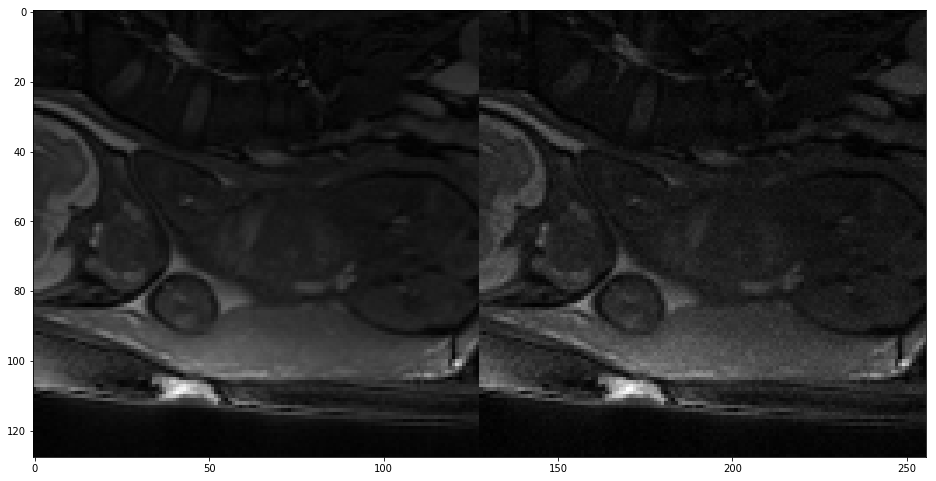

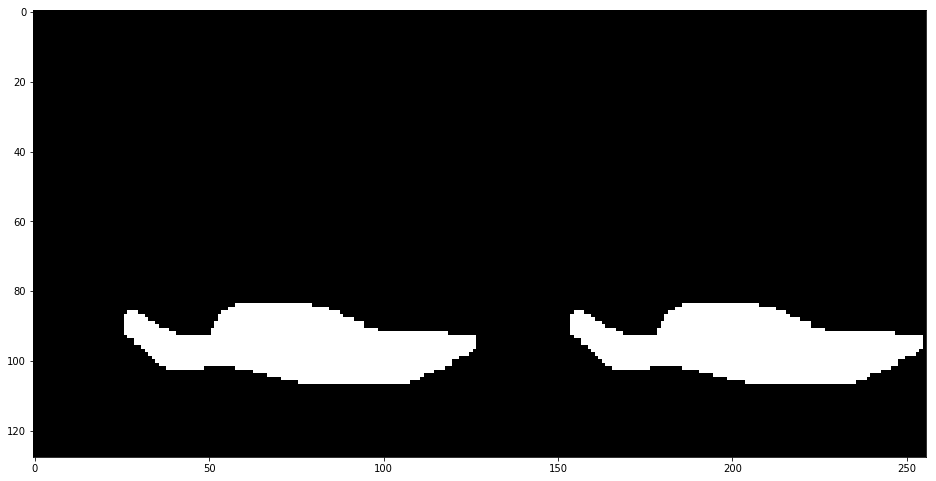

In [16]:
data = vol.get_fdata()
truth = mask.get_fdata()
data2, truth2, _, _, _ = augment_data(data, truth, data.min(), data.max(), data_range=data_range, truth_range=truth_range,
                           poisson_noise=0.5)
plt.figure(figsize = (16,14))
plt.imshow(np.c_[slice_it(data, data_range)[..., 2], data2[..., 2]], cmap='gray')
plt.imsave(r"C:\Users\Shai\Documents\MSc\images\poisson.jpg", np.c_[slice_it(data, data_range)[..., 2], data2[..., 2]], cmap='gray')
plt.figure(figsize = (16,14))
plt.imshow(np.c_[slice_it(truth, truth_range)[..., 0], truth2[..., 0]], cmap='gray')

# contrast deviation

0.0 4047.0


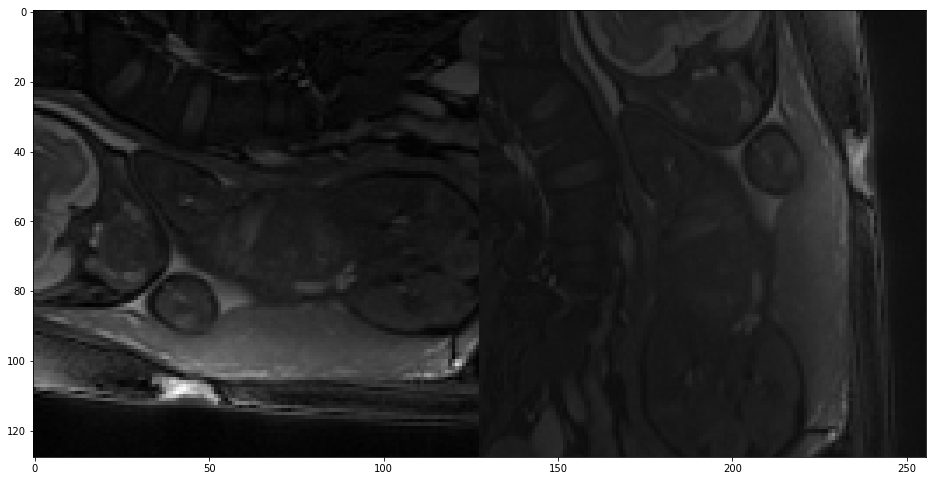

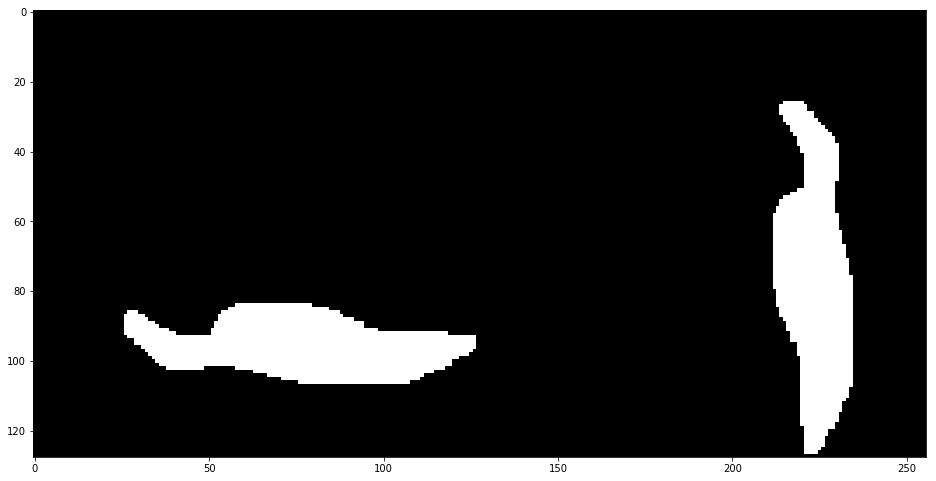

In [32]:
data = vol.get_fdata()
truth = mask.get_fdata()
print(data.min(), data.max())
data2, truth2, _, _, _ = augment_data(data, truth, data.min(), data.max(), data_range=data_range, truth_range=truth_range,
                           contrast_deviation={'min_factor': 0.05, 'max_factor': 0.05})
plt.figure(figsize = (16,14))
plt.imshow(np.c_[slice_it(data, data_range)[..., 2], data2[..., 2]], cmap='gray')
plt.figure(figsize = (16,14))
plt.imshow(np.c_[slice_it(truth, truth_range)[..., 0], truth2[..., 0]], cmap='gray')

# intensity_multiplication_range

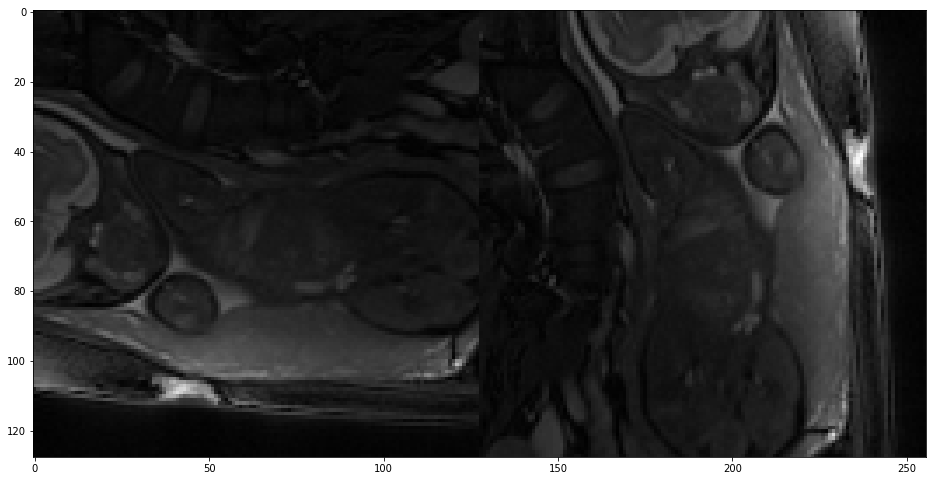

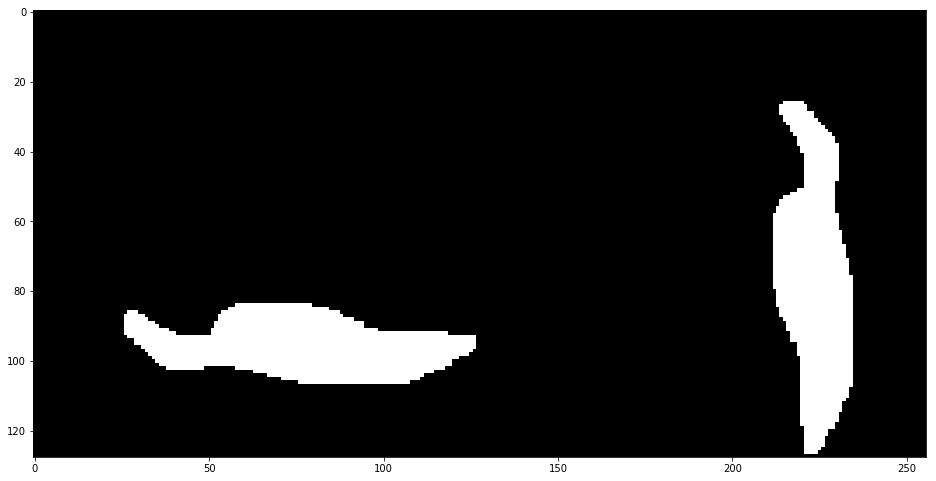

In [37]:
data = vol.get_fdata()
truth = mask.get_fdata()
data2, truth2, _, _, _ = augment_data(data, truth, data.min(), data.max(), data_range=data_range, truth_range=truth_range,
                           intensity_multiplication_range=[0.6, 1.4])
plt.figure(figsize = (16,14))
plt.imshow(np.c_[slice_it(data, data_range)[..., 2], data2[..., 2]], cmap='gray')
plt.figure(figsize = (16,14))
plt.imshow(np.c_[slice_it(truth, truth_range)[..., 0], truth2[..., 0]], cmap='gray')

# piecewise_affine

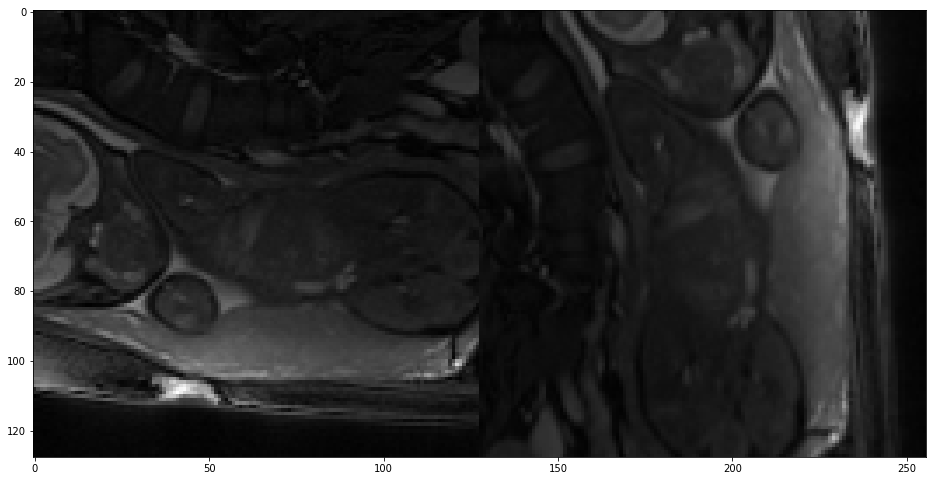

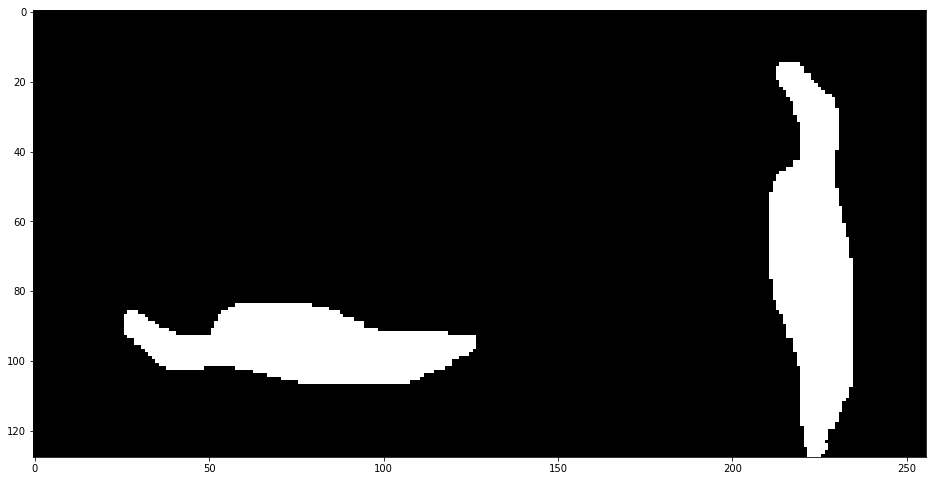

In [58]:
data = vol.get_fdata()
truth = mask.get_fdata()
data2, truth2, _, _, _ = augment_data(data, truth, data.min(), data.max(), data_range=data_range, truth_range=truth_range,
                           piecewise_affine={'scale': 0.7})
plt.figure(figsize = (16,14))
plt.imshow(np.c_[slice_it(data, data_range)[..., 2], data2[..., 2]], cmap='gray')
plt.figure(figsize = (16,14))
plt.imshow(np.c_[slice_it(truth, truth_range)[..., 0], truth2[..., 0]], cmap='gray')

# elastic_transform

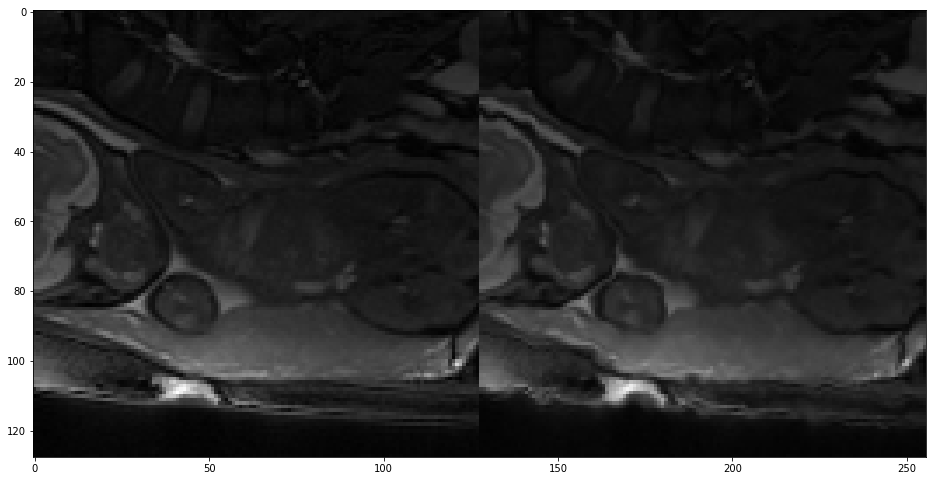

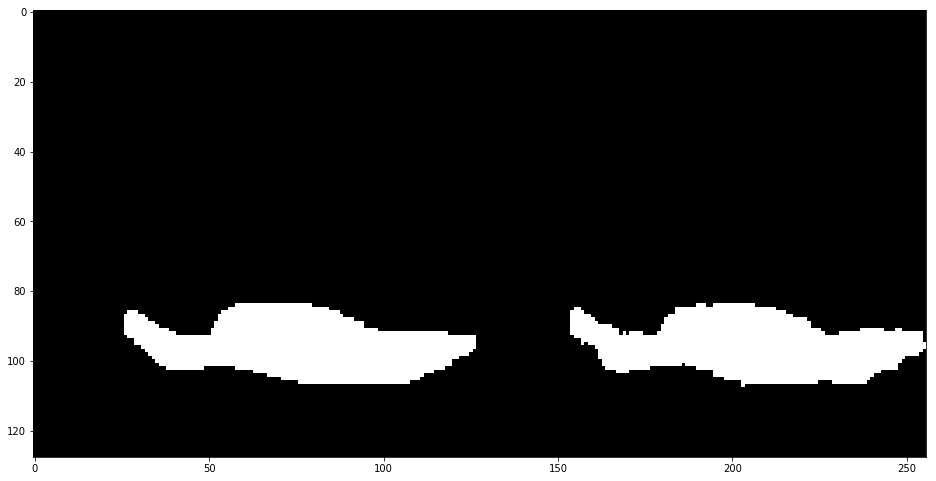

In [54]:
data = vol.get_fdata()
truth = mask.get_fdata()
data2, truth2, _, _, _ = augment_data(data, truth, data.min(), data.max(), data_range=data_range, truth_range=truth_range,
                           elastic_transform={'alpha': 5, 'sigma': 1.5}, transpose_prob=0)
plt.figure(figsize = (16,14))
plt.imshow(np.c_[slice_it(data, data_range)[..., 2], data2[..., 2]], cmap='gray')
plt.figure(figsize = (16,14))
plt.imshow(np.c_[slice_it(truth, truth_range)[..., 0], truth2[..., 0]], cmap='gray')

# scale_deviation

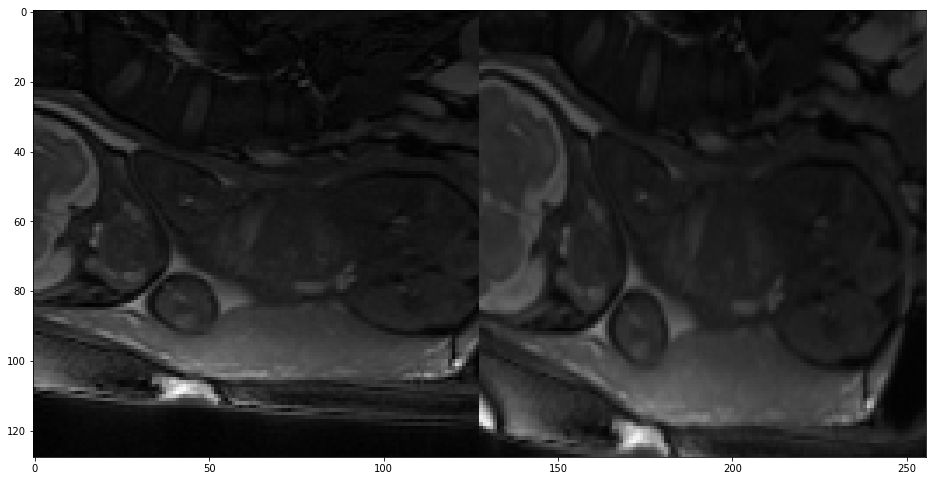

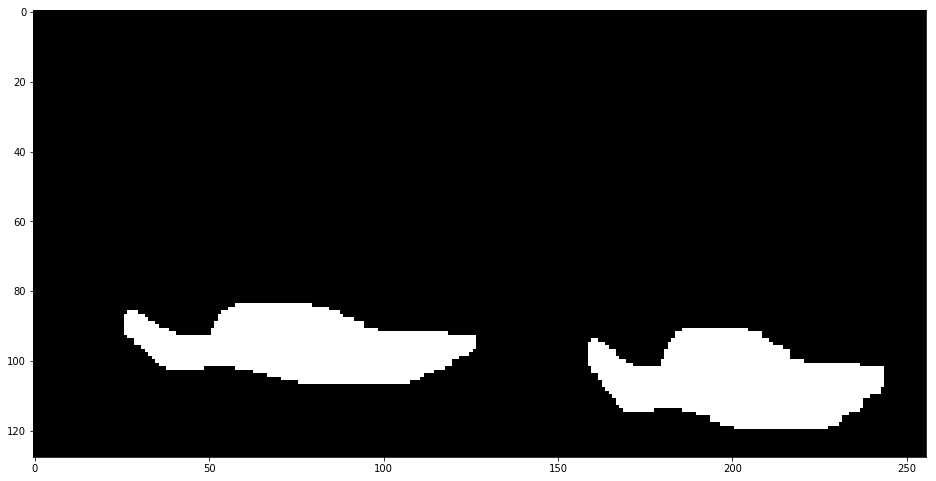

In [14]:
data = vol.get_fdata()
truth = mask.get_fdata()
data2, truth2, _, _, _ = augment_data(data, truth, data.min(), data.max(), data_range=data_range, truth_range=truth_range,
                           scale_deviation=[0.1, 0.1, 0.0], transpose_prob=0)
plt.figure(figsize = (16,14))
plt.imshow(np.c_[slice_it(data, data_range)[..., 2], data2[..., 2]], cmap='gray')
plt.imsave(r"C:\Users\Shai\Documents\MSc\images\scale.jpg", np.c_[slice_it(data, data_range)[..., 2], data2[..., 2]], cmap='gray')
plt.figure(figsize = (16,14))
plt.imshow(np.c_[slice_it(truth, truth_range)[..., 0], truth2[..., 0]], cmap='gray')

# rotate

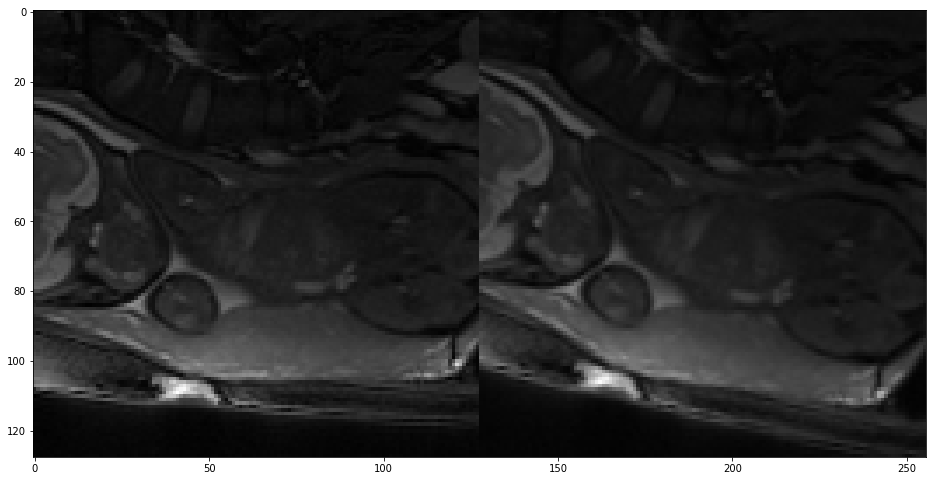

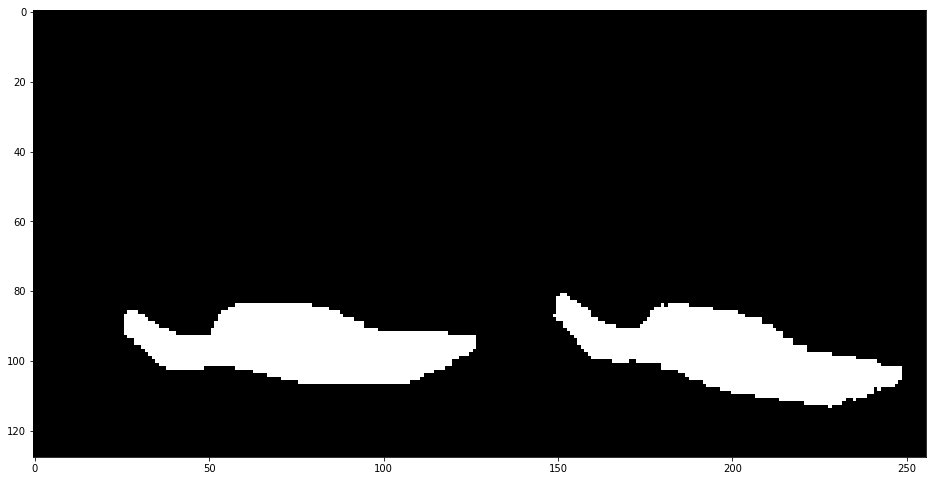

In [63]:
data = vol.get_fdata()
truth = mask.get_fdata()
data2, truth2, _, _, _ = augment_data(data, truth, data.min(), data.max(), data_range=data_range, truth_range=truth_range,
                                rotate_deviation=[0, 0, 30], transpose_prob=0)
plt.figure(figsize = (16,14))
plt.imshow(np.c_[slice_it(data, data_range)[..., 2], data2[..., 2]], cmap='gray')
plt.figure(figsize = (16,14))
plt.imshow(np.c_[slice_it(truth, truth_range)[..., 0], truth2[..., 0]], cmap='gray')

# Flip

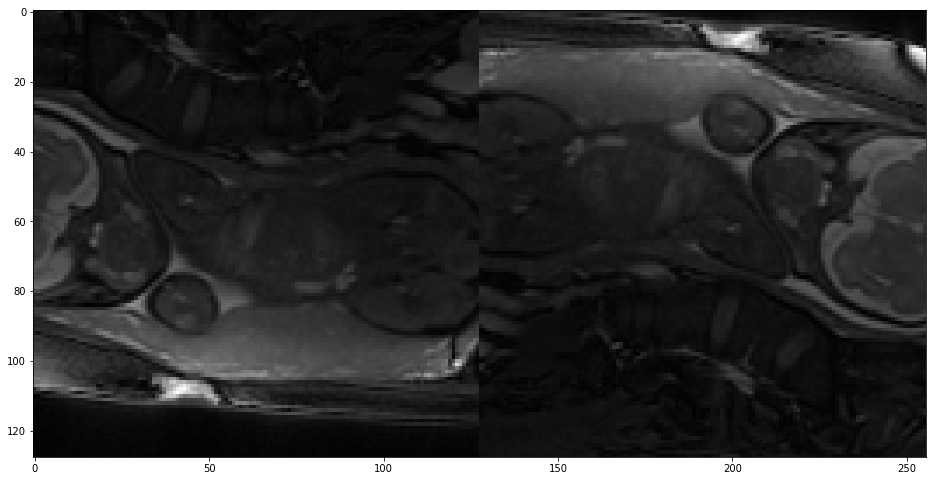

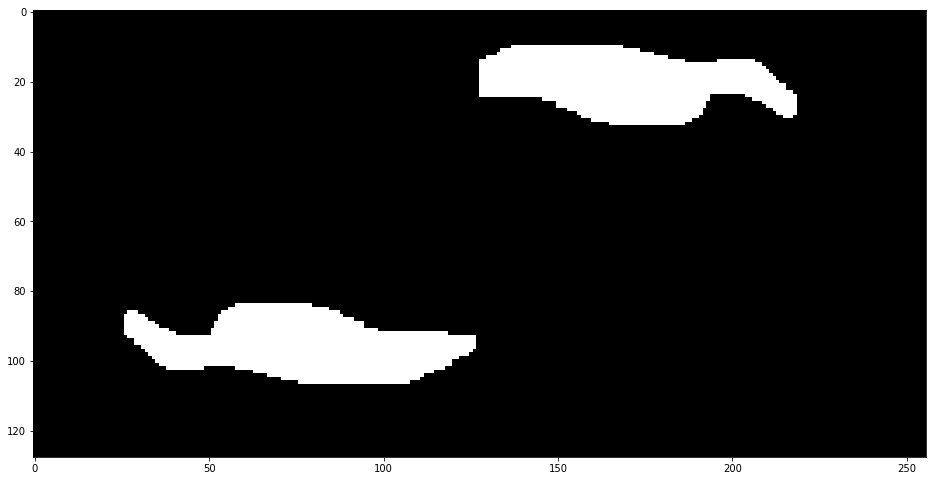

In [15]:
data = vol.get_fdata()
truth = mask.get_fdata()
data2, truth2, _, _, _ = augment_data(data, truth, data.min(), data.max(), data_range=data_range, truth_range=truth_range,
                                flip=[0.4, 0.4, 0.4], transpose_prob=0)
plt.figure(figsize = (16,14))
plt.imshow(np.c_[slice_it(data, data_range)[..., 2], data2[..., 2]], cmap='gray')
plt.imsave(r"C:\Users\Shai\Documents\MSc\images\flip.jpg", np.c_[slice_it(data, data_range)[..., 2], data2[..., 2]], cmap='gray')
plt.figure(figsize = (16,14))
plt.imshow(np.c_[slice_it(truth, truth_range)[..., 0], truth2[..., 0]], cmap='gray')

# Translate

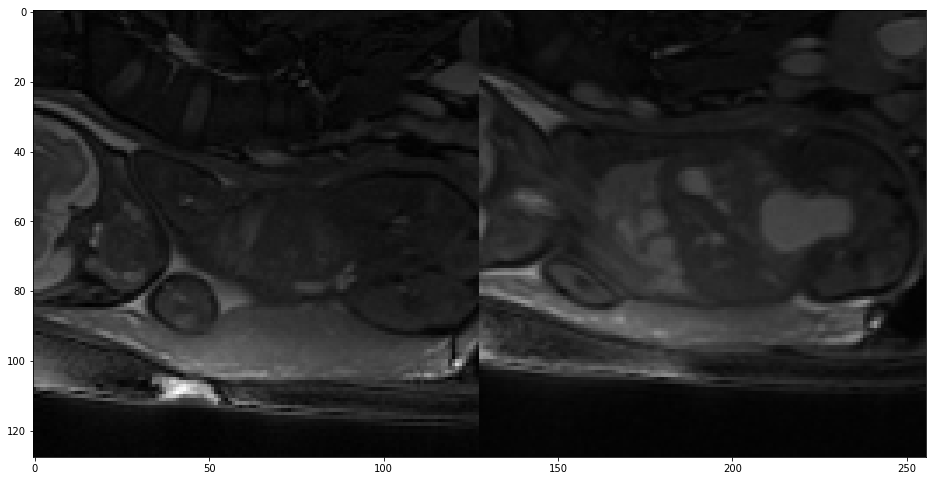

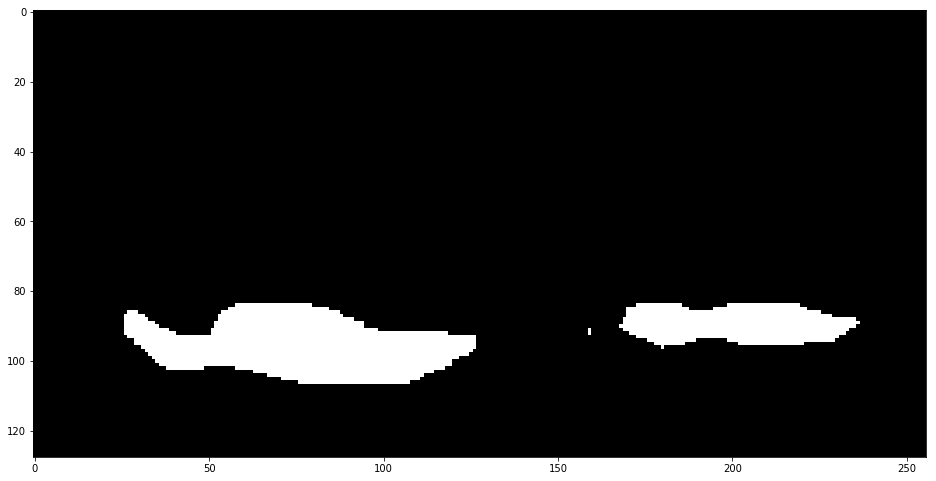

In [12]:
data = vol.get_fdata()
truth = mask.get_fdata()
data2, truth2, _, _, _ = augment_data(data, truth, data.min(), data.max(), data_range=data_range, truth_range=truth_range,
                                translate_deviation=[15, 15, 5], transpose_prob=0)
plt.figure(figsize = (16,14))
plt.imshow(np.c_[slice_it(data, data_range)[..., 2], data2[..., 2]], cmap='gray')
plt.imsave(r"C:\Users\Shai\Documents\MSc\images\translation.jpg", np.c_[slice_it(data, data_range)[..., 2], data2[..., 2]], cmap='gray')
plt.figure(figsize = (16,14))
plt.imshow(np.c_[slice_it(truth, truth_range)[..., 0], truth2[..., 0]], cmap='gray')

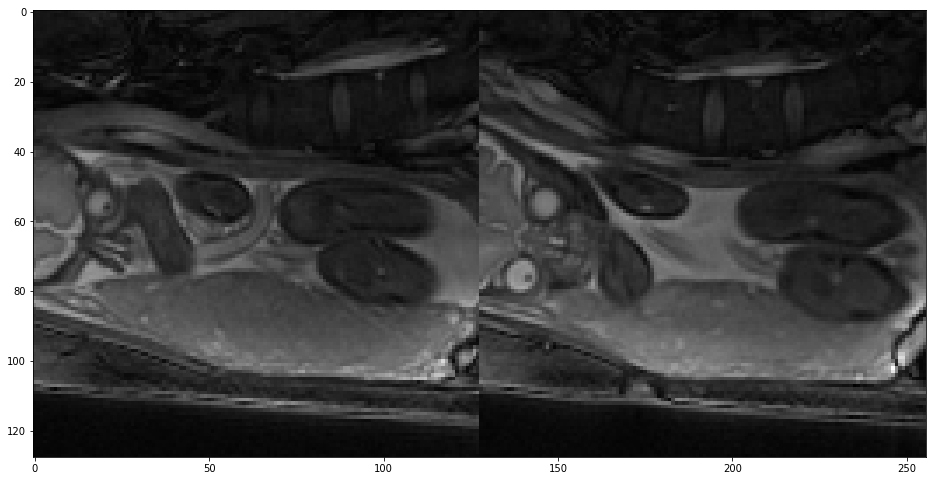

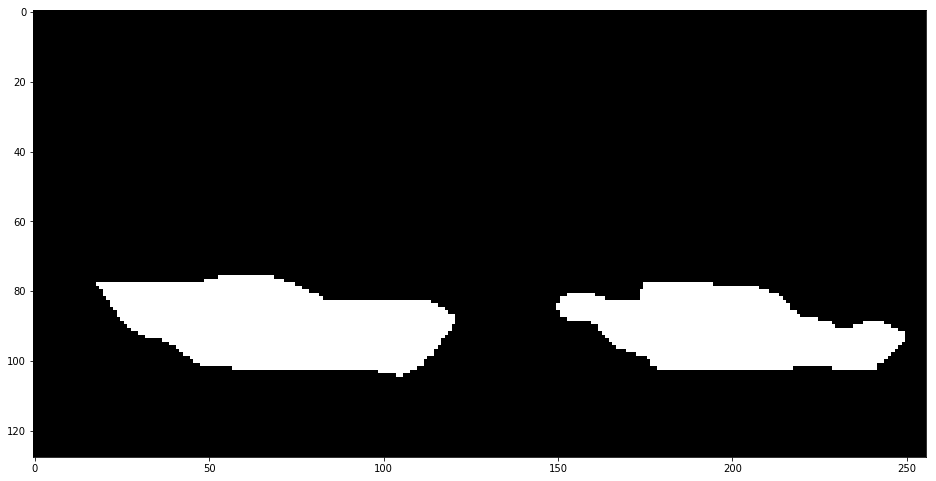

In [69]:
z_trans = 9

data_range2 = data_range.copy()
data_range2[-1] = np.add(data_range2[-1], z_trans)

plt.figure(figsize = (16,14))
plt.imshow(np.c_[slice_it(data, data_range2)[..., 2], data2[..., 2]], cmap='gray')

truth_range2 = truth_range
truth_range2[-1] = np.add(truth_range2[-1], z_trans)
plt.figure(figsize = (16,14))
plt.imshow(np.c_[slice_it(truth, truth_range2)[..., 0], truth2[..., 0]], cmap='gray')

## Coarse Dropout

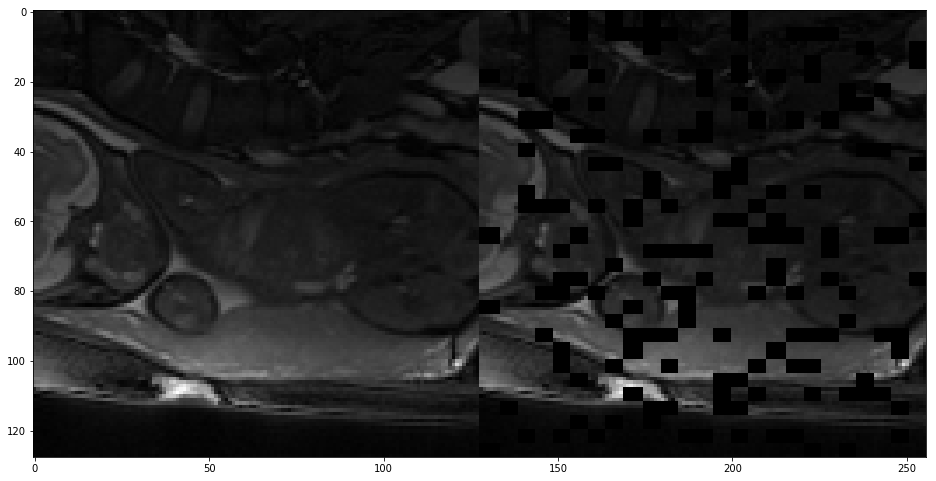

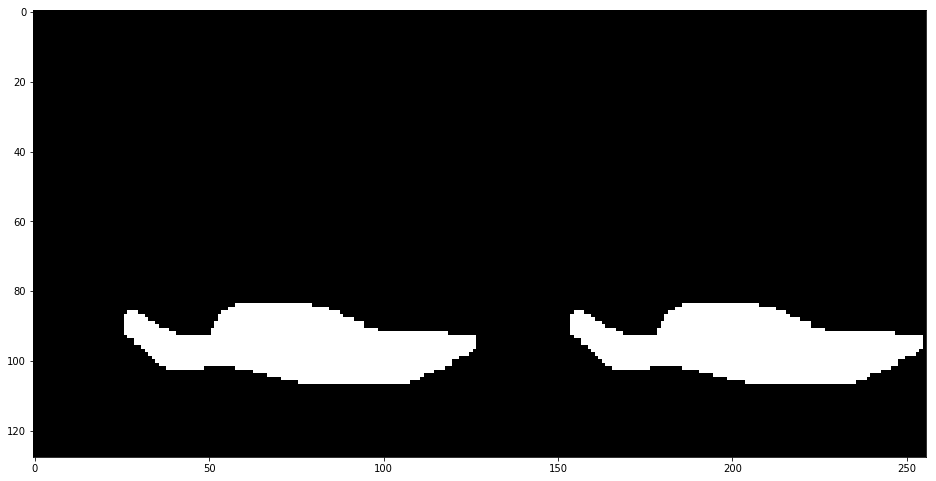

In [17]:
data = vol.get_fdata()
truth = mask.get_fdata()
data2, truth2, _, _, _ = augment_data(data, truth, data.min(), data.max(), data_range=data_range, truth_range=truth_range,
                                coarse_dropout={
                                            "rate": 0.2,
                                            "size_percent": [0.10, 0.30],
                                            "per_channel": True
                                        }, transpose_prob=0)
plt.figure(figsize = (16,14))
plt.imshow(np.c_[slice_it(data, data_range)[..., 2], data2[..., 2]], cmap='gray')
plt.imsave(r"C:\Users\Shai\Documents\MSc\images\coarse_drop.jpg", np.c_[slice_it(data, data_range)[..., 2], data2[..., 2]], cmap='gray')
plt.figure(figsize = (16,14))
plt.imshow(np.c_[slice_it(truth, truth_range)[..., 0], truth2[..., 0]], cmap='gray')

## Visualize post-processing

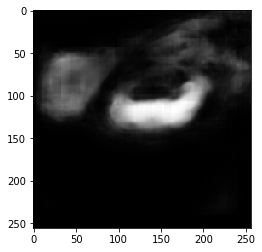

In [48]:
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.morphology import binary_fill_holes

cur_id = 201
pred_path = r"C:\Users\Shai\Documents\PlacentaStuff\configs\augs\exp_good_augs_smaller_probs\predictions\test"
pred_path = os.path.join(pred_path, f'{cur_id}',"prediction.nii.gz")
pred_0 = nib.load(pred_path).get_data()
plt.imshow(pred_0[:,:,70], cmap='gray')
plt.imsave(fr"C:\Users\Shai\Documents\MSc\images\orig_pred_{cur_id}.jpg", pred_0[:,:,70], cmap='gray')

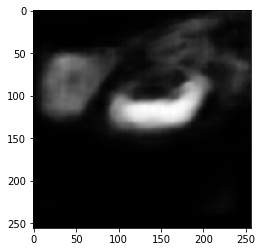

In [49]:
pred = gaussian_filter(pred_0, sigma=1)
plt.imshow(pred[:,:,70], cmap='gray')
plt.imsave(fr"C:\Users\Shai\Documents\MSc\images\pred_after_smoothing_{cur_id}.jpg", pred[:,:,70], cmap='gray')

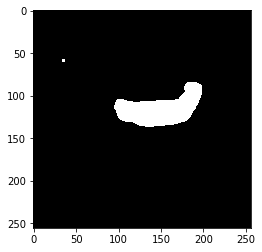

In [50]:
pred = pred > 0.5
plt.imshow(pred[:,:,70], cmap='gray')
plt.imsave(fr"C:\Users\Shai\Documents\MSc\images\pred_after_smoothing_thresh_{cur_id}.jpg", pred[:,:,70], cmap='gray')

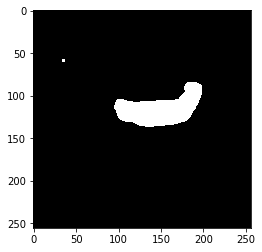

In [51]:
pred2 = binary_fill_holes(pred)
for iSlice in range(pred2.shape[2]):
    if np.any(np.bitwise_xor(pred2[:,:,iSlice], pred[:,:,iSlice])):
        print(iSlice)
plt.imshow(pred2[:,:,70], cmap='gray')
plt.imsave(fr"C:\Users\Shai\Documents\MSc\images\pred_after_smoothing_thresh_fill_{cur_id}.jpg", pred2[:,:,70], cmap='gray')

6
18
19
20
21
22
23
24
25
26
27
28
70


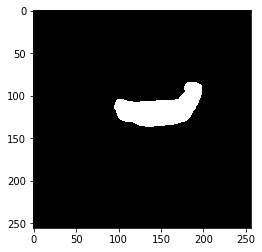

In [52]:
from scipy.ndimage.measurements import label
def get_main_connected_component(data):
    labeled_array, num_features = label(data)
    if num_features > 0:
        i = np.argmax([np.sum(labeled_array == _) for _ in range(1, num_features + 1)]) + 1
    else:
        i = 1
    return labeled_array == i
pred3 = get_main_connected_component(pred2)
for iSlice in range(pred2.shape[2]):
    if np.any(np.bitwise_xor(pred2[:,:,iSlice], pred3[:,:,iSlice])):
        print(iSlice)
plt.imshow(pred3[:,:,70], cmap='gray')
plt.imsave(fr"C:\Users\Shai\Documents\MSc\images\pred_after_smoothing_thresh_fill_maincc_{cur_id}.jpg", pred3[:,:,70], cmap='gray')

In [31]:
True and False

False